In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import wget
import os
import torch
import pytorch_lightning as pl
from omegaconf import OmegaConf
from nemo.collections import nlp as nemo_nlp
from nemo.utils.exp_manager import exp_manager

[NeMo W 2022-02-18 22:49:27 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.decoder_dataset.TextNormalizationDecoderDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-18 22:49:27 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.tagger_dataset.TextNormalizationTaggerDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-18 22:49:27 experimental:27] Module <class 'nemo.collections.nlp.data.text_normalization.test_dataset.TextNormalizationTestDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or ru

In [2]:
abstracts_train = pd.read_csv('abstracts_train.csv', sep='\t')
abstracts_train

,abstract_id,title,abstract
0,1353340,Late-onset metachromatic leukodystrophy: molec...,We report on a new allele at the arylsulfatase...
1,1671881,Two distinct mutations at a single BamHI site ...,Classical phenylketonuria is an autosomal rece...
2,1848636,Debrisoquine phenotype and the pharmacokinetic...,The metabolism of the cardioselective beta-blo...
3,2422478,Midline B3 serotonin nerves in rat medulla are...,Previous experiments in this laboratory have s...
4,2491010,Molecular and phenotypic analysis of patients ...,Eighty unrelated individuals with Duchenne mus...
...,...,...,...
395,28851297,An Ag-globin G->A gene polymorphism associated...,BACKGROUND: Increase of the expression of g-gl...
396,28883039,Disease-associated mutations in human BICD2 hy...,Bicaudal D2 (BICD2) joins dynein with dynactin...
397,29049388,An inducible mouse model of podocin-mutation-r...,"Mutations in the NPHS2 gene, encoding podocin,..."
398,29183288,Arginase 1 deletion in myeloid cells affects t...,BACKGROUND: (Over-)expression of arginase may ...


In [3]:
entities_train = pd.read_csv('entities_train.csv', sep='\t')
entities_train

,id,abstract_id,offset_start,offset_finish,type,mention,entity_ids
0,0,1353340,11,39,DiseaseOrPhenotypicFeature,metachromatic leukodystrophy,D007966
1,1,1353340,111,126,GeneOrGeneProduct,arylsulfatase A,410
2,2,1353340,128,132,GeneOrGeneProduct,ARSA,410
3,3,1353340,159,187,DiseaseOrPhenotypicFeature,metachromatic leukodystrophy,D007966
4,4,1353340,189,192,DiseaseOrPhenotypicFeature,MLD,D007966
...,...,...,...,...,...,...,...
13631,13631,30836660,2237,2241,GeneOrGeneProduct,TLR4,"21898,7099"
13632,13632,30836660,2242,2251,GeneOrGeneProduct,NF-kappaB,"18033,4790"
13633,13633,30836660,2256,2260,GeneOrGeneProduct,MAPK,"26413,5594"
13634,13634,30836660,2344,2347,ChemicalEntity,Sal,C009172


In [43]:
entities_train['type'].value_counts()

GeneOrGeneProduct             4764
DiseaseOrPhenotypicFeature    3784
ChemicalEntity                2540
OrganismTaxon                 1420
SequenceVariant               1011
CellLine                       117
Name: type, dtype: int64

In [12]:
text = abstracts_train['title'].iloc[0] + ' ' + abstracts_train['abstract'].iloc[0]
text

'Late-onset metachromatic leukodystrophy: molecular pathology in two siblings. We report on a new allele at the arylsulfatase A (ARSA) locus causing late-onset metachromatic leukodystrophy (MLD). In that allele arginine84, a residue that is highly conserved in the arylsulfatase gene family, is replaced by glutamine. In contrast to alleles that cause early-onset MLD, the arginine84 to glutamine substitution is associated with some residual ARSA activity. A comparison of genotypes, ARSA activities, and clinical data on 4 individuals carrying the allele of 81 patients with MLD examined, further validates the concept that different degrees of residual ARSA activity are the basis of phenotypical variation in MLD.. '

In [6]:
text[:-2]

'Late-onset metachromatic leukodystrophy: molecular pathology in two siblings. We report on a new allele at the arylsulfatase A (ARSA) locus causing late-onset metachromatic leukodystrophy (MLD). In that allele arginine84, a residue that is highly conserved in the arylsulfatase gene family, is replaced by glutamine. In contrast to alleles that cause early-onset MLD, the arginine84 to glutamine substitution is associated with some residual ARSA activity. A comparison of genotypes, ARSA activities, and clinical data on 4 individuals carrying the allele of 81 patients with MLD examined, further validates the concept that different degrees of residual ARSA activity are the basis of phenotypical variation in MLD.'

# Convert into IOB

In [4]:
train_narratives_data, dev_narratives_data = train_test_split(abstracts_train, test_size=0.2)

In [26]:
SYMBOLS = '{}#()[].,:;+-*/&|<>=~ "\''
entire_data_idx = 0
final_word_list = []
final_IOB_list = []
final_EID_list = []
final_AID_list = []

while entire_data_idx < len(train_narratives_data):
# while entire_data_idx < len(dev_narratives_data):
    sub_narratives_data = train_narratives_data['title'].iloc[entire_data_idx] + ' ' + train_narratives_data['abstract'].iloc[entire_data_idx]
    # sub_narratives_data = dev_narratives_data['title'].iloc[entire_data_idx] + ' ' + dev_narratives_data['abstract'].iloc[entire_data_idx]
    if sub_narratives_data[-3:] == '.. ':
        sub_narratives_data = sub_narratives_data[:-2]

    sub_clinical_data = entities_train[entities_train['abstract_id'] == train_narratives_data['abstract_id'].iloc[entire_data_idx]]
    # sub_clinical_data = entities_train[entities_train['abstract_id'] == dev_narratives_data['abstract_id'].iloc[entire_data_idx]]

    new_START_POS = []
    new_END_POS = []

    # Generate word list
    word = ''
    tmp_word_list = []
    dotCount = 0
    for i in sub_narratives_data:
        if i in SYMBOLS:
            if i == ' ':
                if dotCount == 1:
                    tmp_word_list.append('')
                    dotCount = 0
                if word != '':
                    tmp_word_list.append(word)
            else:
                if dotCount == 1:
                    dotCount = 0
                if word != '':
                    tmp_word_list.append(word)
                tmp_word_list.append(i)
            if i == '.':
                dotCount = 1
            word = ''
        else:
            if dotCount == 1:
                dotCount = 0
            word += i

    if word != '':
        tmp_word_list.append(word)

    # Generate new START_POS and new END_POS lists
    for idx in range(len(sub_clinical_data)):
        word = ''
        word_count = 0
        narratives_before_feature_text = sub_narratives_data[0:sub_clinical_data['offset_start'].iloc[idx]]
        dotCount = 0
        for i in narratives_before_feature_text:
            if i in SYMBOLS:
                if i == ' ':
                    if dotCount == 1:
                        word_count += 1
                        dotCount = 0
                    if word != '':
                        word_count += 1
                else:
                    if dotCount == 1:
                        dotCount = 0
                    if word != '':
                        word_count += 1
                    word_count += 1
                if i == '.':
                    dotCount = 1
                word = ''
            else:
                if dotCount == 1:
                    dotCount = 0
                word += i

        if word != '':
            word_count += 1

        new_START_POS.append(word_count)

        word = ''
        word_count = 0
        narratives_before_feature_text = sub_narratives_data[0:sub_clinical_data['offset_finish'].iloc[idx]]
        dotCount = 0
        for i in narratives_before_feature_text:
            if i in SYMBOLS:
                if i == ' ':
                    if dotCount == 1:
                        word_count += 1
                        dotCount = 0
                    if word != '':
                        word_count += 1
                else:
                    if dotCount == 1:
                        dotCount = 0
                    if word != '':
                        word_count += 1
                    word_count += 1
                if i == '.':
                    dotCount = 1
                word = ''
            else:
                if dotCount == 1:
                    dotCount = 0
                word += i

        if word != '':
            word_count += 1

        new_END_POS.append(word_count)

    # Generate IOB list
    tmp_IOB_list = ['O'] * len(tmp_word_list)
    tmp_EID_list = ['O'] * len(tmp_word_list)
    tmp_AID_list = [sub_clinical_data['abstract_id'].iloc[0]] * len(tmp_word_list)
    for idx in range(len(new_START_POS)):
        tmp_IOB_list[new_START_POS[idx] : new_END_POS[idx]] = ['B-' + sub_clinical_data['type'].iloc[idx]] * (new_END_POS[idx] - new_START_POS[idx])
        tmp_EID_list[new_START_POS[idx] : new_END_POS[idx]] = [sub_clinical_data['entity_ids'].iloc[idx]] * (new_END_POS[idx] - new_START_POS[idx])

        if new_END_POS[idx] - new_START_POS[idx] > 1:
            tmp_IOB_list[new_START_POS[idx] + 1 : new_END_POS[idx]] = ['I-' + sub_clinical_data['type'].iloc[idx]] * (new_END_POS[idx] - new_START_POS[idx] - 1)
            tmp_EID_list[new_START_POS[idx] + 1 : new_END_POS[idx]] = [sub_clinical_data['entity_ids'].iloc[idx]] * (new_END_POS[idx] - new_START_POS[idx] - 1)

        for idx2 in range(new_END_POS[idx] - new_START_POS[idx]):
            if tmp_word_list[new_START_POS[idx] + idx2] in SYMBOLS:
                tmp_IOB_list[new_START_POS[idx] + idx2] = 'O'
                tmp_EID_list[new_START_POS[idx] + idx2] = 'O'

    for idx in range(len(tmp_word_list)):
        if tmp_word_list[idx] == '':
            if tmp_word_list[idx - 1] == '.':
                tmp_IOB_list[idx] = ''
                tmp_EID_list[idx] = ''
                tmp_AID_list[idx] = ''

    # Merge into a final word list and a final IOB list
    final_word_list += tmp_word_list
    final_IOB_list += tmp_IOB_list
    final_EID_list += tmp_EID_list
    final_AID_list += tmp_AID_list
    entire_data_idx += 1

In [27]:
output = pd.DataFrame({'word':final_word_list, 'IOB':final_IOB_list, 'EID':final_EID_list, 'AID':final_AID_list})
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(output)
len(output)

104104

In [28]:
with open('train_LitCoin_IOB.tsv', 'w') as f:
# with open('dev_LitCoin_IOB.tsv', 'w') as f:
    for idx in tqdm(range(len(output))):
        if output['word'].iloc[idx] == '':
            f.write('\n')
        else:
            output[['word', 'IOB']].iloc[[idx]].to_csv(f, index=False, header=False, sep='\t', mode='a')

with open('train_LitCoin_EID.tsv', 'w') as f:
# with open('dev_LitCoin_EID.tsv', 'w') as f:
    for idx in tqdm(range(len(output))):
        if output['word'].iloc[idx] == '':
            f.write('\n')
        else:
            output[['word', 'EID']].iloc[[idx]].to_csv(f, index=False, header=False, sep='\t', mode='a')

with open('train_LitCoin_AID.tsv', 'w') as f:
# with open('dev_LitCoin_AID.tsv', 'w') as f:
    for idx in tqdm(range(len(output))):
        if output['word'].iloc[idx] == '':
            f.write('\n')
        else:
            output[['word', 'AID']].iloc[[idx]].to_csv(f, index=False, header=False, sep='\t', mode='a')

100%|██████████| 104104/104104 [05:05<00:00, 340.39it/s]


# NER

In [2]:
BRANCH = 'r1.4.0'
wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/token_classification/data/import_from_iob_format.py')

'import_from_iob_format.py'

In [3]:
! python import_from_iob_format.py --data_file=train_LitCoin_IOB.tsv
! python import_from_iob_format.py --data_file=dev_LitCoin_IOB.tsv

[NeMo I 2022-02-18 22:49:32 import_from_iob_format:119] Processing train_LitCoin_IOB.tsv
[NeMo I 2022-02-18 22:49:32 import_from_iob_format:124] Processing of the train_LitCoin_IOB.tsv is complete
[NeMo I 2022-02-18 22:49:36 import_from_iob_format:119] Processing dev_LitCoin_IOB.tsv
[NeMo I 2022-02-18 22:49:36 import_from_iob_format:124] Processing of the dev_LitCoin_IOB.tsv is complete


In [4]:
MODEL_CONFIG = "token_classification_config.yaml"

In [5]:
if not os.path.exists(MODEL_CONFIG):
    print('Downloading config file...')
    wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/token_classification/conf/' + MODEL_CONFIG, './')
else:
    print ('config file is already exists')

In [6]:
config = OmegaConf.load(f'{MODEL_CONFIG}')
config.model.train_ds.batch_size=64
config.model.train_ds.text_file='text_train_LitCoin_IOB.txt'
config.model.train_ds.labels_file='labels_train_LitCoin_IOB.txt'
config.model.validation_ds.batch_size=64
config.model.validation_ds.text_file='text_dev_LitCoin_IOB.txt'
config.model.validation_ds.labels_file='labels_dev_LitCoin_IOB.txt'
config.model.test_ds.text_file='text_dev_LitCoin_IOB.txt'
config.model.test_ds.labels_file='labels_dev_LitCoin_IOB.txt'
config.model.dataset.data_dir = './'
config.trainer.max_epochs = 7

In [7]:
print(OmegaConf.to_yaml(config))

pretrained_model: null
trainer:
  gpus: 1
  num_nodes: 1
  max_epochs: 7
  max_steps: null
  accumulate_grad_batches: 1
  gradient_clip_val: 0.0
  amp_level: O0
  precision: 16
  accelerator: ddp
  checkpoint_callback: false
  logger: false
  log_every_n_steps: 1
  val_check_interval: 1.0
  resume_from_checkpoint: null
exp_manager:
  exp_dir: null
  name: token_classification_model
  create_tensorboard_logger: true
  create_checkpoint_callback: true
model:
  label_ids: null
  class_labels:
    class_labels_file: label_ids.csv
  dataset:
    data_dir: ./
    class_balancing: null
    max_seq_length: 128
    pad_label: O
    ignore_extra_tokens: false
    ignore_start_end: false
    use_cache: true
    num_workers: 2
    pin_memory: false
    drop_last: false
  train_ds:
    text_file: text_train_LitCoin_IOB.txt
    labels_file: labels_train_LitCoin_IOB.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
  validation_ds:
    text_file: text_dev_LitCoin_IOB.txt
    labels_file: l

In [8]:
# lets modify some trainer configs
# checks if we have GPU available and uses it
cuda = 1 if torch.cuda.is_available() else 0
config.trainer.gpus = cuda

# for PyTorch Native AMP set precision=16
config.trainer.precision = 16 if torch.cuda.is_available() else 32

# remove distributed training flags
config.trainer.accelerator = None

trainer = pl.Trainer(**config.trainer)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
exp_dir = exp_manager(trainer, config.get("exp_manager", None))

# the exp_dir provides a path to the current experiment for easy access
exp_dir = str(exp_dir)
exp_dir

[NeMo I 2022-02-18 22:49:37 exp_manager:220] Experiments will be logged at /workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37
[NeMo I 2022-02-18 22:49:37 exp_manager:569] TensorboardLogger has been set up


[NeMo W 2022-02-18 22:49:37 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:240: LightningDeprecationWarning: `ModelCheckpoint(every_n_val_epochs)` is deprecated in v1.4 and will be removed in v1.6. Please use `every_n_epochs` instead.
      rank_zero_deprecation(
    


'/workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37'

In [10]:
# complete list of supported BERT-like models
print(nemo_nlp.modules.get_pretrained_lm_models_list())

PRETRAINED_BERT_MODEL = "biomegatron-bert-345m-cased"

['megatron-bert-345m-uncased', 'megatron-bert-345m-cased', 'megatron-bert-uncased', 'megatron-bert-cased', 'biomegatron-bert-345m-uncased', 'biomegatron-bert-345m-cased', 'bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'cl-tohoku/bert-base-japanese', 'cl-tohoku/bert-base-japanese-whole-word-masking', 'cl-tohoku/bert-base-japanese-char', 'cl-tohoku/bert-base-japanese-char-whole-word-masking', 'TurkuNLP/bert-base-finnish-cased-v1', 'TurkuNLP/bert-base-finnish-uncased-v1', 'wietsedv/bert-base-dutch-cased', 'distilbert-base-uncased', 'distilbert-base-uncased-

In [11]:
config.model.language_model.pretrained_model_name = PRETRAINED_BERT_MODEL

In [12]:
model_ner = nemo_nlp.models.TokenClassificationModel(cfg=config.model, trainer=trainer)

[NeMo I 2022-02-18 22:49:39 megatron_utils:274] Downloading from https://api.ngc.nvidia.com/v2/models/nvidia/biomegatron345mcased/versions/0/files/vocab.txt
[NeMo I 2022-02-18 22:49:40 tokenizer_utils:100] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-large-cased, vocab_file: /root/.cache/torch/megatron/biomegatron-bert-345m-cased_vocab, special_tokens_dict: {}, and use_fast: False


I0218 22:49:40.593445 139808715183936 filelock.py:274] Lock 139805817868736 acquired on /root/.cache/huggingface/transformers/45d2aa048795efc7b12791662c188d5e3aa2f9ac54b2cf3f6e4d7bc6544e3d13.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

I0218 22:49:40.901526 139808715183936 filelock.py:318] Lock 139805817868736 released on /root/.cache/huggingface/transformers/45d2aa048795efc7b12791662c188d5e3aa2f9ac54b2cf3f6e4d7bc6544e3d13.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
I0218 22:49:41.176199 139808715183936 filelock.py:274] Lock 139805817853504 acquired on /root/.cache/huggingface/transformers/11ad22b0deaa199d15b331609ca5f60872a1a91473e9b40c115192dadb6d9a30.bdf0177a774dcff07681b2527b926c099e6563687c75a79f7469c7a7da7898c7.lock


Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

I0218 22:49:41.475332 139808715183936 filelock.py:318] Lock 139805817853504 released on /root/.cache/huggingface/transformers/11ad22b0deaa199d15b331609ca5f60872a1a91473e9b40c115192dadb6d9a30.bdf0177a774dcff07681b2527b926c099e6563687c75a79f7469c7a7da7898c7.lock
I0218 22:49:42.028901 139808715183936 filelock.py:274] Lock 139805817854320 acquired on /root/.cache/huggingface/transformers/c9961ea5b7e8ad58701728c45f4d225f70b19aa59745121e5a96c8a44efca4c8.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

I0218 22:49:42.554241 139808715183936 filelock.py:318] Lock 139805817854320 released on /root/.cache/huggingface/transformers/c9961ea5b7e8ad58701728c45f4d225f70b19aa59745121e5a96c8a44efca4c8.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
I0218 22:49:43.650928 139808715183936 filelock.py:274] Lock 139805817600176 acquired on /root/.cache/huggingface/transformers/75be22d7750034989358861e325977feda47740e1c3f8a4dc1cb73570aad843e.2b9a196704f2f183fe3f4b48d6e662dba8203fdcb3346bfa896831378edf6f97.lock


Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

I0218 22:49:44.241148 139808715183936 filelock.py:318] Lock 139805817600176 released on /root/.cache/huggingface/transformers/75be22d7750034989358861e325977feda47740e1c3f8a4dc1cb73570aad843e.2b9a196704f2f183fe3f4b48d6e662dba8203fdcb3346bfa896831378edf6f97.lock
Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.


[NeMo I 2022-02-18 22:49:44 token_classification_utils:54] Processing ./labels_train_LitCoin_IOB.txt
[NeMo I 2022-02-18 22:49:44 token_classification_utils:90] Labels mapping {'O': 0, 'B-CellLine': 1, 'B-ChemicalEntity': 2, 'B-DiseaseOrPhenotypicFeature': 3, 'B-GeneOrGeneProduct': 4, 'B-OrganismTaxon': 5, 'B-SequenceVariant': 6, 'I-CellLine': 7, 'I-ChemicalEntity': 8, 'I-DiseaseOrPhenotypicFeature': 9, 'I-GeneOrGeneProduct': 10, 'I-OrganismTaxon': 11, 'I-SequenceVariant': 12} saved to : ./label_ids.csv
[NeMo I 2022-02-18 22:49:45 token_classification_utils:99] Three most popular labels in ./labels_train_LitCoin_IOB.txt:
[NeMo I 2022-02-18 22:49:45 data_preprocessing:194] label: 0, 84007 out of 100857 (83.29%).
[NeMo I 2022-02-18 22:49:45 data_preprocessing:194] label: 4, 3903 out of 100857 (3.87%).
[NeMo I 2022-02-18 22:49:45 data_preprocessing:194] label: 3, 3052 out of 100857 (3.03%).
[NeMo I 2022-02-18 22:49:45 token_classification_utils:101] Total labels: 100857. Label frequencies 

[NeMo W 2022-02-18 22:49:51 token_classification_dataset:150] 25 are longer than 128


[NeMo I 2022-02-18 22:49:51 token_classification_dataset:153] *** Example ***
[NeMo I 2022-02-18 22:49:51 token_classification_dataset:154] i: 0
[NeMo I 2022-02-18 22:49:51 token_classification_dataset:155] subtokens: [CLS] Micro ##in ##jection of r ##ita ##nse ##rin into the CA ##1 region of hip ##po ##cam ##pus improve ##s s ##co ##pol ##amine - induced am ##nesia in adult male rats . [SEP]
[NeMo I 2022-02-18 22:49:51 token_classification_dataset:156] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2022-02-18 22:49:51 token_classification_dataset:157] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2022-02-18 22:49:53 token_classification_dataset:150] 3 are longer than 128


[NeMo I 2022-02-18 22:49:53 token_classification_dataset:153] *** Example ***
[NeMo I 2022-02-18 22:49:53 token_classification_dataset:154] i: 0
[NeMo I 2022-02-18 22:49:53 token_classification_dataset:155] subtokens: [CLS] Alt ##ered replication timing of the H ##IR ##A / Tu ##ple ##1 lo ##cus in the Di ##G ##eor ##ge and V ##elo ##card ##io ##fa ##cial syndrome ##s . [SEP]
[NeMo I 2022-02-18 22:49:53 token_classification_dataset:156] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2022-02-18 22:49:53 token_classification_dataset:157] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2022-02-18 22:49:53 modelPT:197] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2022-02-18 22:49:53 megatron_utils:274] Downloading from https://api.ngc.nvidia.com/v2/models/nvidia/biomegatron345mcased/versions/0/files/MegatronBERT.pt
using world size: 1, data-parallel-size: 1, tensor-model-parallel size: 1, pipeline-model-parallel size: 1 
setting global batch size to 1
using torch.float32 for parameters ...
------------------------ arguments ------------------------
  adam_beta1 ...................................... 0.9
  adam_beta2 ...................................... 0.999
  adam_eps ........................................ 1e-08
  adlr_autoresume ................................. False
  adlr_autoresume_interval ........................ 1000
  apply_query_key_layer_scaling ................... True
  apply_residual_connection_post_layernorm ........ False
  attention_dropout ............................... 0.1
  attention_softmax_in_fp32 ....................... False
  bert_load ....................................... None
  bias_dropout_fusion ....

[NeMo W 2022-02-18 22:50:28 megatron_bert:204] Megatron-lm checkpoint version not found. Setting checkpoint_version to 0.


[NeMo I 2022-02-18 22:50:30 megatron_bert:212] Checkpoint loaded from from /root/.cache/torch/megatron/biomegatron-bert-345m-cased


In [13]:
# start model training
trainer.fit(model_ner)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-02-18 22:50:33 modelPT:544] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        lr: 5e-05
        weight_decay: 0.0
    )
[NeMo I 2022-02-18 22:50:33 lr_scheduler:621] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7f26ff936100>" 
    will be used during training (effective maximum steps = 357) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 357
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | MegatronBertEncoder  | 332 M 
1 | classifier            | TokenClassifier      | 1.1 M 
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     
---------------------------------------------------------------
333 M     Trainable params
0         Non-trainable params
333 M     Total params
1,334.616 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-02-18 22:50:33 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


> initializing torch distributed ...


I0218 22:50:34.109622 139808715183936 distributed_c10d.py:214] Added key: store_based_barrier_key:1 to store for rank: 0
I0218 22:50:34.111293 139808715183936 distributed_c10d.py:248] Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.
I0218 22:50:34.113165 139808715183936 distributed_c10d.py:214] Added key: store_based_barrier_key:2 to store for rank: 0
I0218 22:50:34.113949 139808715183936 distributed_c10d.py:248] Rank 0: Completed store-based barrier for key:store_based_barrier_key:2 with 1 nodes.
I0218 22:50:34.115290 139808715183936 distributed_c10d.py:214] Added key: store_based_barrier_key:3 to store for rank: 0
I0218 22:50:34.115967 139808715183936 distributed_c10d.py:248] Rank 0: Completed store-based barrier for key:store_based_barrier_key:3 with 1 nodes.
I0218 22:50:34.117381 139808715183936 distributed_c10d.py:214] Added key: store_based_barrier_key:4 to store for rank: 0
I0218 22:50:34.118261 139808715183936 distributed_c10d.py:248] Rank 0

> initializing tensor model parallel with size 1
> initializing pipeline model parallel with size 1
> setting random seeds to 1234 ...
> initializing model parallel cuda seeds on global rank 0, model parallel rank 0, and data parallel rank 0 with model parallel seed: 3952 and data parallel seed: 1234
[NeMo I 2022-02-18 22:50:36 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         90.43      22.13      35.56       3158
    B-CellLine (label_id: 1)                                 0.00       0.00       0.00          0
    B-ChemicalEntity (label_id: 2)                           2.99       3.33       3.15         60
    B-DiseaseOrPhenotypicFeature (label_id: 3)               2.27       8.70       3.60         92
    B-GeneOrGeneProduct (label_id: 4)                        0.27       0.89       0.41        112
    B-OrganismTaxon (label_id: 5)  

[NeMo W 2022-02-18 22:50:36 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 22:51:13 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         97.03      98.75      97.88      20753
    B-CellLine (label_id: 1)                                 0.00       0.00       0.00         30
    B-ChemicalEntity (label_id: 2)                          76.60      84.80      80.49        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              56.36      91.10      69.63        730
    B-GeneOrGeneProduct (label_id: 4)                       84.64      92.17      88.25        843
    B-OrganismTaxon (label_id: 5)                            0.00       0.00       0.00        227
    B-SequenceVariant (label_id: 6)                         41.58      87.96      56.47        191
    I-CellLine (label_id: 7)                                 0.00       0.00       0.00         12
    I-ChemicalEntity (label_id: 8)      

Epoch 0, global step 50: val_loss reached 0.30717 (best 0.30717), saving model to "/workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37/checkpoints/token_classification_model--val_loss=0.3072-epoch=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 22:53:10 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         98.84      98.32      98.58      20753
    B-CellLine (label_id: 1)                                71.79      93.33      81.16         30
    B-ChemicalEntity (label_id: 2)                          86.31      89.08      87.67        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              78.67      88.90      83.47        730
    B-GeneOrGeneProduct (label_id: 4)                       95.01      92.53      93.75        843
    B-OrganismTaxon (label_id: 5)                           86.09      87.22      86.65        227
    B-SequenceVariant (label_id: 6)                         70.35      83.25      76.26        191
    I-CellLine (label_id: 7)                                 0.00       0.00       0.00         12
    I-ChemicalEntity (label_id: 8)      

Epoch 1, global step 101: val_loss reached 0.16128 (best 0.16128), saving model to "/workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37/checkpoints/token_classification_model--val_loss=0.1613-epoch=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 22:55:07 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.02      98.22      98.62      20753
    B-CellLine (label_id: 1)                                72.50      96.67      82.86         30
    B-ChemicalEntity (label_id: 2)                          88.24      89.94      89.08        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              83.79      84.25      84.02        730
    B-GeneOrGeneProduct (label_id: 4)                       94.86      94.19      94.52        843
    B-OrganismTaxon (label_id: 5)                           85.27      96.92      90.72        227
    B-SequenceVariant (label_id: 6)                         69.92      86.39      77.28        191
    I-CellLine (label_id: 7)                                 0.00       0.00       0.00         12
    I-ChemicalEntity (label_id: 8)      

Epoch 2, global step 152: val_loss reached 0.15300 (best 0.15300), saving model to "/workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37/checkpoints/token_classification_model--val_loss=0.1530-epoch=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 22:56:59 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.01      98.36      98.69      20753
    B-CellLine (label_id: 1)                                80.56      96.67      87.88         30
    B-ChemicalEntity (label_id: 2)                          89.76      88.22      88.98        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              81.67      87.26      84.37        730
    B-GeneOrGeneProduct (label_id: 4)                       93.69      95.14      94.41        843
    B-OrganismTaxon (label_id: 5)                           88.05      97.36      92.47        227
    B-SequenceVariant (label_id: 6)                         85.49      86.39      85.94        191
    I-CellLine (label_id: 7)                               100.00      33.33      50.00         12
    I-ChemicalEntity (label_id: 8)      

Epoch 3, global step 203: val_loss reached 0.15913 (best 0.15300), saving model to "/workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37/checkpoints/token_classification_model--val_loss=0.1591-epoch=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 22:59:09 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.01      98.41      98.71      20753
    B-CellLine (label_id: 1)                                90.91     100.00      95.24         30
    B-ChemicalEntity (label_id: 2)                          89.89      89.51      89.70        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              84.31      86.85      85.56        730
    B-GeneOrGeneProduct (label_id: 4)                       94.03      95.26      94.64        843
    B-OrganismTaxon (label_id: 5)                           84.85      98.68      91.24        227
    B-SequenceVariant (label_id: 6)                         84.16      89.01      86.51        191
    I-CellLine (label_id: 7)                               100.00      83.33      90.91         12
    I-ChemicalEntity (label_id: 8)      

Epoch 4, global step 254: val_loss reached 0.15971 (best 0.15300), saving model to "/workspace/nemo/nemo_experiments/token_classification_model/2022-02-18_22-49-37/checkpoints/token_classification_model--val_loss=0.1597-epoch=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 23:00:55 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.04      98.31      98.67      20753
    B-CellLine (label_id: 1)                                93.75     100.00      96.77         30
    B-ChemicalEntity (label_id: 2)                          88.49      90.58      89.52        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              85.41      87.40      86.39        730
    B-GeneOrGeneProduct (label_id: 4)                       93.69      95.14      94.41        843
    B-OrganismTaxon (label_id: 5)                           86.77      98.24      92.15        227
    B-SequenceVariant (label_id: 6)                         80.57      89.01      84.58        191
    I-CellLine (label_id: 7)                               100.00      91.67      95.65         12
    I-ChemicalEntity (label_id: 8)      

Epoch 5, global step 305: val_loss was not in top 3


Validating: 0it [00:00, ?it/s]

[NeMo I 2022-02-18 23:02:08 token_classification_model:176] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.07      98.29      98.68      20753
    B-CellLine (label_id: 1)                                93.75     100.00      96.77         30
    B-ChemicalEntity (label_id: 2)                          90.52      89.94      90.23        467
    B-DiseaseOrPhenotypicFeature (label_id: 3)              84.82      87.26      86.02        730
    B-GeneOrGeneProduct (label_id: 4)                       93.81      95.26      94.53        843
    B-OrganismTaxon (label_id: 5)                           86.49      98.68      92.18        227
    B-SequenceVariant (label_id: 6)                         80.19      89.01      84.37        191
    I-CellLine (label_id: 7)                               100.00      91.67      95.65         12
    I-ChemicalEntity (label_id: 8)      

Epoch 6, global step 356: val_loss was not in top 3


[NeMo I 2022-02-18 23:04:58 token_classification_dataset:121] Setting Max Seq length to: 240
[NeMo I 2022-02-18 23:04:58 data_preprocessing:358] Some stats of the lengths of the sequences:
[NeMo I 2022-02-18 23:04:58 data_preprocessing:360] Min: 4 |                  Max: 240 |                  Mean: 44.443361753958584 |                  Median: 40.0
[NeMo I 2022-02-18 23:04:58 data_preprocessing:366] 75 percentile: 54.00
[NeMo I 2022-02-18 23:04:58 data_preprocessing:367] 99 percentile: 115.80


[NeMo W 2022-02-18 23:04:58 token_classification_dataset:150] 0 are longer than 240


[NeMo I 2022-02-18 23:04:58 token_classification_dataset:153] *** Example ***
[NeMo I 2022-02-18 23:04:58 token_classification_dataset:154] i: 0
[NeMo I 2022-02-18 23:04:58 token_classification_dataset:155] subtokens: [CLS] Alt ##ered replication timing of the H ##IR ##A / Tu ##ple ##1 lo ##cus in the Di ##G ##eor ##ge and V ##elo ##card ##io ##fa ##cial syndrome ##s . [SEP]
[NeMo I 2022-02-18 23:04:58 token_classification_dataset:156] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2022-02-18 23:04:58 token_classification_dataset:157] input_m

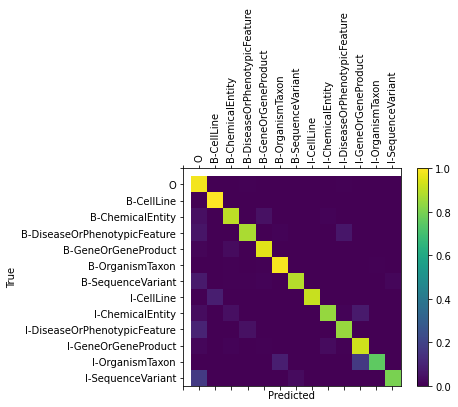

In [14]:
model_ner.evaluate_from_file(
    text_file='./text_dev_LitCoin_IOB.txt',
    labels_file='./labels_dev_LitCoin_IOB.txt',
    output_dir=exp_dir,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
)

# Entity Classification

In [15]:
!pip3 install seaborn

     |████████████████████████████████| 292 kB 26.0 MB/s eta 0:00:01


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [18]:
infer_text_test = pd.read_csv('infer_text_dev_LitCoin_IOB.txt', sep='\t', header=None)
infer_text_test

,0,1
0,labels,O O O O O B-GeneOrGeneProduct O B-GeneOrGenePr...
1,preds,O O O O O B-GeneOrGeneProduct O B-GeneOrGenePr...


In [19]:
TOKEN_LABEL_DIC = {'O':0, 'B-CellLine':1, 'B-ChemicalEntity':2,
                   'B-DiseaseOrPhenotypicFeature':3, 'B-GeneOrGeneProduct':4,
                   'B-OrganismTaxon':5, 'B-SequenceVariant':6, 'I-CellLine':7,
                   'I-ChemicalEntity':8, 'I-DiseaseOrPhenotypicFeature':9,
                   'I-GeneOrGeneProduct':10, 'I-OrganismTaxon':11, 'I-SequenceVariant':12}
ENTITY_LABEL_DIC = {'O':0, 'B-CellLine':1, 'B-ChemicalEntity':2,
                    'B-DiseaseOrPhenotypicFeature':3, 'B-GeneOrGeneProduct':4,
                    'B-OrganismTaxon':5, 'B-SequenceVariant':6, 'I-CellLine':1,
                    'I-ChemicalEntity':2, 'I-DiseaseOrPhenotypicFeature':3,
                    'I-GeneOrGeneProduct':4, 'I-OrganismTaxon':5, 'I-SequenceVariant':6}
TOKEN_LABELS = TOKEN_LABEL_DIC.keys()
ENTITY_LABELS = ['O', 'CellLine', 'ChemicalEntity', 'DiseaseOrPhenotypicFeature',
                 'GeneOrGeneProduct', 'OrganismTaxon', 'SequenceVariant']

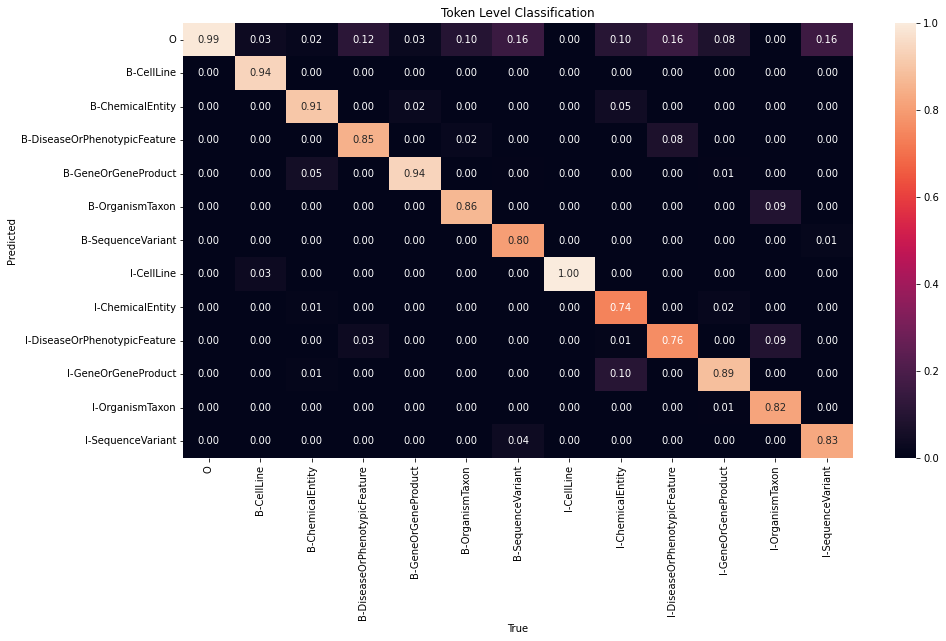

In [20]:
labels_infer_text_test = infer_text_test[1].iloc[0].split(' ')
preds_infer_text_test = infer_text_test[1].iloc[1].split(' ')
labels_infer_text_test = [TOKEN_LABEL_DIC[i] for i in labels_infer_text_test]
preds_infer_text_test = [TOKEN_LABEL_DIC[i] for i in preds_infer_text_test]

confMatrix = confusion_matrix(labels_infer_text_test, preds_infer_text_test)
confMatrix = confMatrix / confMatrix.astype(float).sum(axis=0)

plt.figure(figsize=(15, 8))
ax = sn.heatmap(confMatrix, annot=True, fmt='.2f', xticklabels=TOKEN_LABELS, yticklabels=TOKEN_LABELS)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('Token Level Classification')
plt.show()

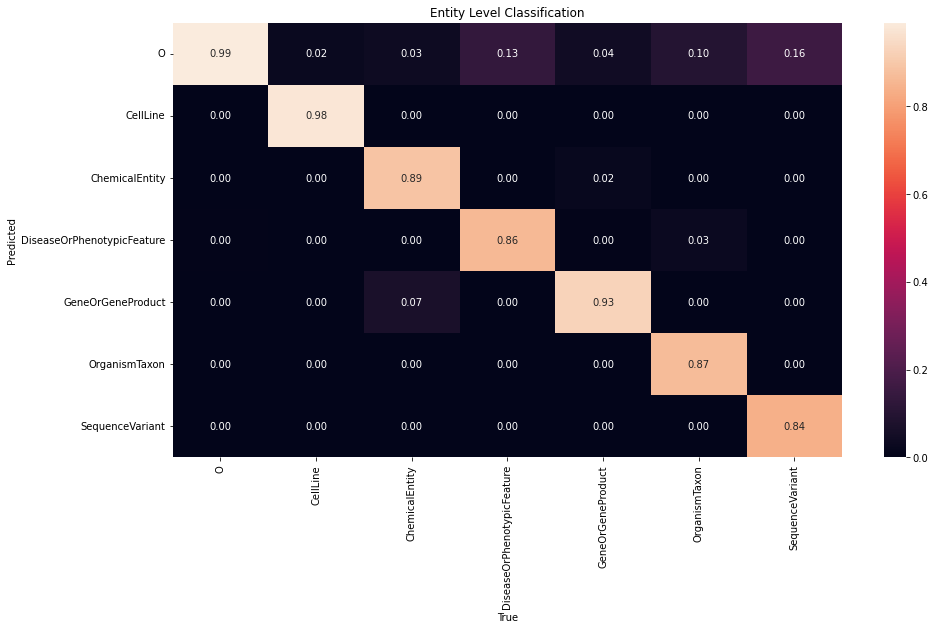

In [21]:
labels_infer_text_test = infer_text_test[1].iloc[0].split(' ')
preds_infer_text_test = infer_text_test[1].iloc[1].split(' ')
labels_infer_text_test = [ENTITY_LABEL_DIC[i] for i in labels_infer_text_test]
preds_infer_text_test = [ENTITY_LABEL_DIC[i] for i in preds_infer_text_test]

confMatrix = confusion_matrix(labels_infer_text_test, preds_infer_text_test)
confMatrix = confMatrix / confMatrix.astype(float).sum(axis=0)

plt.figure(figsize=(15, 8))
ax = sn.heatmap(confMatrix, annot=True, fmt='.2f', xticklabels=ENTITY_LABELS, yticklabels=ENTITY_LABELS)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('Entity Level Classification')
plt.show()

In [22]:
query = ['Late-onset metachromatic leukodystrophy: molecular pathology in two siblings.']
model_ner.add_predictions(queries=query, batch_size=64, output_file='tmp.txt')

[NeMo I 2022-02-18 23:12:24 token_classification_dataset:121] Setting Max Seq length to: 21
[NeMo I 2022-02-18 23:12:24 data_preprocessing:358] Some stats of the lengths of the sequences:
[NeMo I 2022-02-18 23:12:24 data_preprocessing:360] Min: 21 |                  Max: 21 |                  Mean: 21.0 |                  Median: 21.0
[NeMo I 2022-02-18 23:12:24 data_preprocessing:366] 75 percentile: 21.00
[NeMo I 2022-02-18 23:12:24 data_preprocessing:367] 99 percentile: 21.00


[NeMo W 2022-02-18 23:12:24 token_classification_dataset:150] 0 are longer than 21


[NeMo I 2022-02-18 23:12:24 token_classification_dataset:153] *** Example ***
[NeMo I 2022-02-18 23:12:24 token_classification_dataset:154] i: 0
[NeMo I 2022-02-18 23:12:24 token_classification_dataset:155] subtokens: [CLS] Late - onset meta ##ch ##romatic le ##uk ##ody ##stro ##phy : molecular path ##ology in two siblings . [SEP]
[NeMo I 2022-02-18 23:12:24 token_classification_dataset:156] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[NeMo I 2022-02-18 23:12:24 token_classification_dataset:157] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[NeMo I 2022-02-18 23:12:24 token_classification_dataset:158] subtokens_mask: 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0
[NeMo I 2022-02-18 23:12:24 token_classification_model:435] Predictions saved to tmp.txt


['Late-onset metachromatic[B-DiseaseOrPhenotypicFeature] leukodystrophy[I-DiseaseOrPhenotypicFeature]: molecular pathology in two siblings.']